In [1]:
import numpy as np
from pathlib import Path
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt

import sys
sys.path.extend(['../../scripts','../../scripts/xenium'])
import readwrite
cfg = readwrite.config()

/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead

## panel

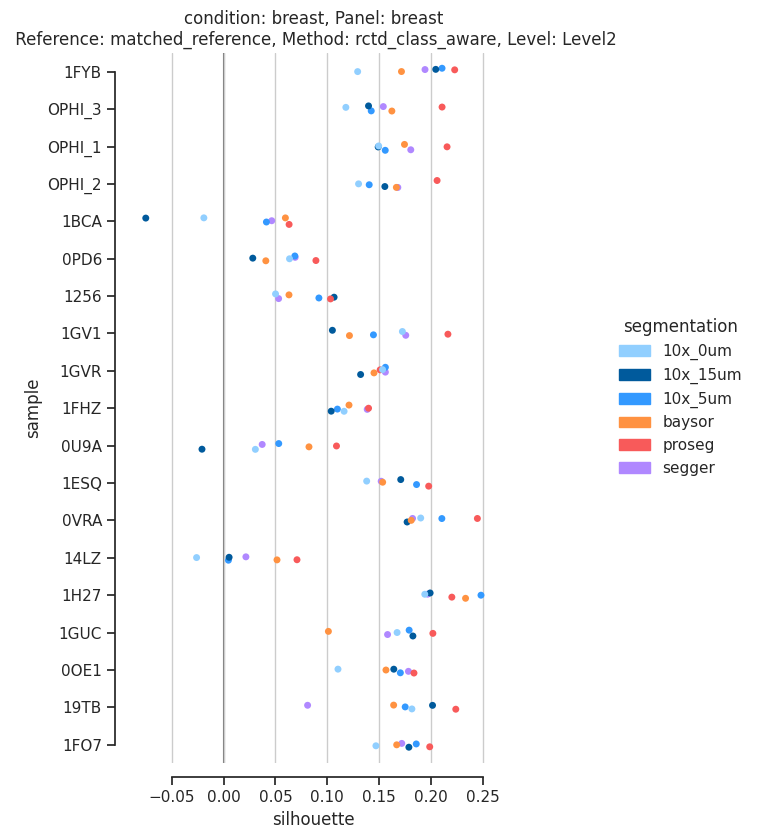

In [3]:
import argparse
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from pathlib import Path

# Access the arguments
panel = Path('/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/silhouette/proseg/breast/breast/')
silhouette_dir = panel.parents[2]
segmentation_palette = Path('/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/metadata/col_palette_segmentation.csv')
reference = 'matched_reference'
method = 'rctd_class_aware'
level = 'Level2'

plot_panel = panel.stem
plot_condition = panel.parents[0].stem

palette = pd.read_csv(segmentation_palette,index_col=0)['cols_segmentation']

# vars
xenium_levels = ["segmentation", "condition", "panel", "donor", "sample", "index"]

# read cell type annotation
annot = {}
for segmentation in (segmentations := silhouette_dir.iterdir()):
    for condition in (conditions := segmentation.iterdir()):
        if condition.stem != plot_condition:
            continue
        for panel in (panels := condition.iterdir()):
            if panel.stem != plot_panel:
                continue
            for donor in (donors := panel.iterdir()):
                for sample in (samples := donor.iterdir()):
                    k = (
                        segmentation.stem,
                        condition.stem,
                        panel.stem,
                        donor.stem,
                        sample.stem,
                    )

                    annot[k] = {}
                    annot_file = sample / "silhouette.parquet"
                    if annot_file.exists():
                        annot[k] = pd.read_parquet(annot_file)

# merge annotations
df_annot = pd.concat(annot)
df_annot = df_annot.reset_index()
df_annot.columns = xenium_levels + df_annot.columns[len(xenium_levels) :].tolist()

df = df_annot.query(
    f"condition == '{plot_condition}' and panel == '{plot_panel}' and reference == '{reference}' and method == '{method}' and level == '{level}'"
)

# plotting params, palette
title = f"condition: {plot_condition}, Panel: {plot_panel}\n Reference: {reference}, Method: {method}, Level: {level}"
hue = "segmentation"
unique_labels = np.unique(df[hue].dropna())
palette = {u: palette[u] for u in unique_labels} 
legend_handles = [
    mpatches.Patch(color=color, label=label) for label, color in palette.items()
]


# Create joint boxplot
sns.set(style="ticks")
f = plt.figure(figsize=(6, df["sample"].nunique()//2))
g = sns.stripplot(
    data=df, x="silhouette", y="sample", hue=hue, legend=False, palette=palette
)  # , cut=0, width=1,inner='quart')

sns.despine(offset=10, trim=True)
plt.gca().xaxis.grid(True)
plt.axvline(0, c="k", linestyle="-", zorder=0, alpha=0.6)

plt.title(title)
f.legend(
    handles=legend_handles,
    loc="center left",
    bbox_to_anchor=(1, 0.5),
    title=hue,
    frameon=False,
)
plt.tight_layout(rect=[0, 0, 0.85, 0.95])

## panel violinplot

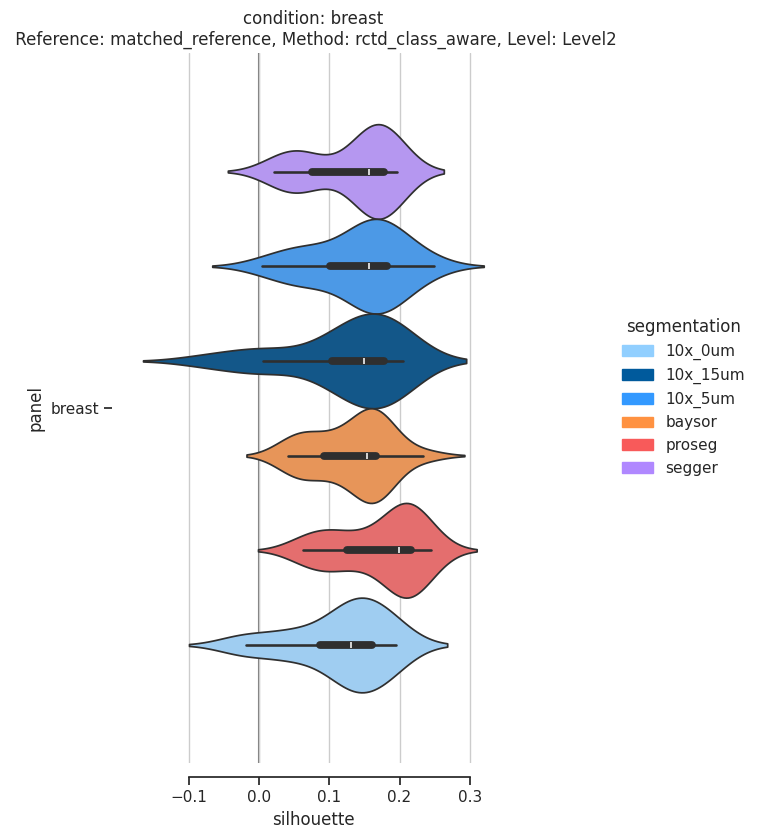

In [9]:
import argparse
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from pathlib import Path

# Access the arguments
condition = Path('/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/silhouette/proseg/breast/')
silhouette_dir = panel.parents[2]
segmentation_palette = Path('/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/metadata/col_palette_segmentation.csv')
reference = 'matched_reference'
method = 'rctd_class_aware'
level = 'Level2'

plot_condition = condition.stem

palette = pd.read_csv(segmentation_palette,index_col=0)['cols_segmentation']

# vars
xenium_levels = ["segmentation", "condition", "panel", "donor", "sample", "index"]

# read cell type annotation
annot = {}
for segmentation in (segmentations := silhouette_dir.iterdir()):
    for condition in (conditions := segmentation.iterdir()):
        if condition.stem != plot_condition:
            continue
        for panel in (panels := condition.iterdir()):
            # if panel.stem != plot_panel:
            #     continue
            for donor in (donors := panel.iterdir()):
                for sample in (samples := donor.iterdir()):
                    k = (
                        segmentation.stem,
                        condition.stem,
                        panel.stem,
                        donor.stem,
                        sample.stem,
                    )

                    annot[k] = {}
                    annot_file = sample / "silhouette.parquet"
                    if annot_file.exists():
                        annot[k] = pd.read_parquet(annot_file)

# merge annotations
df_annot = pd.concat(annot)
df_annot = df_annot.reset_index()
df_annot.columns = xenium_levels + df_annot.columns[len(xenium_levels) :].tolist()

df = df_annot.query(
    f"condition == '{plot_condition}' and reference == '{reference}' and method == '{method}' and level == '{level}'"
)

# plotting params, palette
title = f"condition: {plot_condition}\n Reference: {reference}, Method: {method}, Level: {level}"
hue = "segmentation"
unique_labels = np.unique(df[hue].dropna())
palette = {u: palette[u] for u in unique_labels} 
legend_handles = [
    mpatches.Patch(color=color, label=label) for label, color in palette.items()
]


# Create joint boxplot
sns.set(style="ticks")
f = plt.figure(figsize=(6, df["sample"].nunique()//2))
g = sns.violinplot(
    data=df, x="silhouette", y="panel", hue=hue, legend=False, palette=palette
)  # , cut=0, width=1,inner='quart')

sns.despine(offset=10, trim=True)
plt.gca().xaxis.grid(True)
plt.axvline(0, c="k", linestyle="-", zorder=0, alpha=0.6)

plt.title(title)
f.legend(
    handles=legend_handles,
    loc="center left",
    bbox_to_anchor=(1, 0.5),
    title=hue,
    frameon=False,
)
plt.tight_layout(rect=[0, 0, 0.85, 0.95])

## condition violinplot

['10x_0um', '10x_5um', '10x_15um', 'baysor', 'proseg', 'segger']

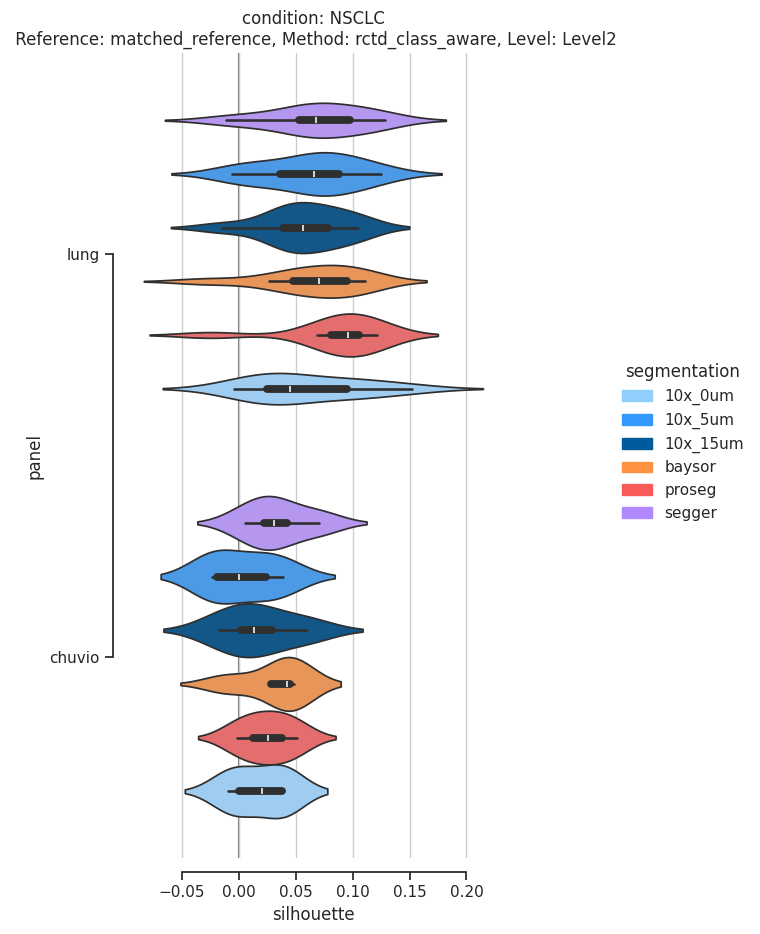

In [ ]:
import argparse
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import natsort
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from pathlib import Path

# Access the arguments
condition = Path('/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/silhouette/proseg/NSCLC/')
silhouette_dir = condition.parents[1]
segmentation_palette = Path('/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/metadata/col_palette_segmentation.csv')
reference = 'matched_reference'
method = 'rctd_class_aware'
level = 'Level2'

plot_condition = condition.stem

palette = pd.read_csv(segmentation_palette,index_col=0)['cols_segmentation']

# vars
xenium_levels = ["segmentation", "condition", "panel", "donor", "sample", "index"]

# read cell type annotation
annot = {}
for segmentation in (segmentations := silhouette_dir.iterdir()):
    for condition in (conditions := segmentation.iterdir()):
        if condition.stem != plot_condition:
            continue
        for panel in (panels := condition.iterdir()):
            # if panel.stem != plot_panel:
            #     continue
            for donor in (donors := panel.iterdir()):
                for sample in (samples := donor.iterdir()):
                    k = (
                        segmentation.stem,
                        condition.stem,
                        panel.stem,
                        donor.stem,
                        sample.stem,
                    )

                    annot[k] = {}
                    annot_file = sample / "silhouette.parquet"
                    if annot_file.exists():
                        annot[k] = pd.read_parquet(annot_file)

# merge annotations
df_annot = pd.concat(annot)
df_annot = df_annot.reset_index()
df_annot.columns = xenium_levels + df_annot.columns[len(xenium_levels) :].tolist()

df = df_annot.query(
    f"condition == '{plot_condition}' and reference == '{reference}' and method == '{method}' and level == '{level}'"
)

# plotting params, palette
title = f"condition: {plot_condition}\n Reference: {reference}, Method: {method}, Level: {level}"
hue = "segmentation"
unique_labels = natsort.natsorted(np.unique(df[hue].dropna()))
palette = {u: palette[u] for u in unique_labels} 
legend_handles = [
    mpatches.Patch(color=color, label=label) for label, color in palette.items()
]


# Create joint boxplot
sns.set(style="ticks")
f = plt.figure(figsize=(6, df["panel"].nunique()*5))
g = sns.violinplot(
    data=df, x="silhouette", y="panel", hue=hue, hue_order=unique_labels, legend=False, palette=palette
)  # , cut=0, width=1,inner='quart')

sns.despine(offset=10, trim=True)
plt.gca().xaxis.grid(True)
plt.axvline(0, c="k", linestyle="-", zorder=0, alpha=0.6)

plt.title(title)
f.legend(
    handles=legend_handles,
    loc="center left",
    bbox_to_anchor=(1, 0.5),
    title=hue,
    frameon=False,
)
plt.tight_layout(rect=[0, 0, 0.85, 0.95])